## Задание 1

[kaggle task](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

Есть датасет с характеристиками покупателей в магазине.
<br>
Требуется разбить покупателей на k кластеров (выбор k остается за тобой), посчитать силуэт и визуализировать полученные кластеры

Выбор k должен быть обоснован, применять можно абсолютно любые алгоритмы.

**Заметка**: можно генерировать новые признаки и/или не использовать все имеющиеся, да и вообще делать все, что угодно и не противоречит здравому смыслу :)

**Не забывай фиксировать random_state для воспроизводимости результатов, где это требуется**

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

from pathlib import Path

##other libraries on need##

In [23]:
df = pd.read_csv(Path('..', 'data', 'mall_customers.csv'))
print(df.shape)
df.head(50)
df.shape

(200, 5)


(200, 5)

Переименуем некоторые признаки. В описании данных написано, что речь идет о супермаркете. А в них обычно находятся продукты, товары для быта и вещи первой необходимости. Таким образом, предлагаю исключить признак пола, так как вряд ли он сильно влияет на то, как покупают люди (мужчинам и женщинам плюс-минус нужно одно и то же). Само собой, идентификатор тоже выбрасываем.

In [3]:
df = df.rename(columns={"Annual Income (k$)": "Income","Spending Score (1-100)" : "Score" })
df = df.replace("Male", 0)
df = df.replace("Female", 1)
X = df
X = X.drop(columns=['CustomerID', 'Gender'])
Xv = X.values

В итоге имеем 3 признака. Построим набор точек для каждой пары признаков. Очень четкие группы точек видны на графике доход - покупательская способность, в третьем графике меньше, в первом - довольно равномерно

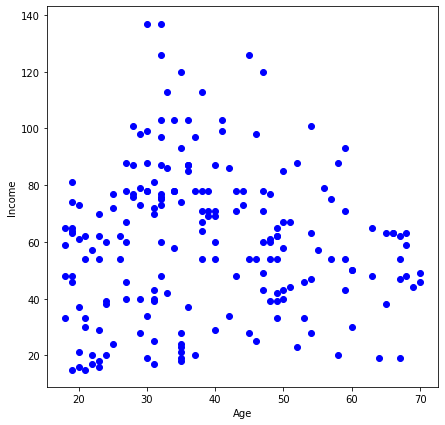

In [4]:
plt.figure(figsize=(7, 7))
plt.scatter( Xv[:, 0], Xv[:, 1], c='blue');
plt.xlabel('Age')
plt.ylabel('Income');

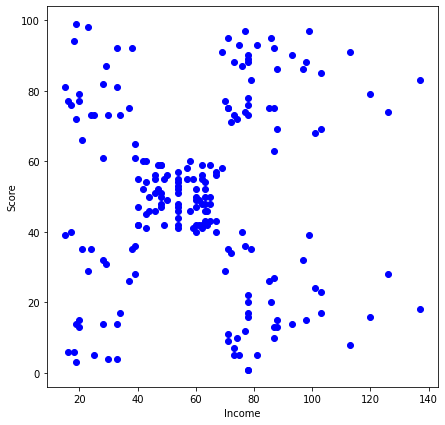

In [5]:
plt.figure(figsize=(7, 7))
plt.scatter( Xv[:, 1], Xv[:, 2], c='blue');
plt.xlabel('Income')
plt.ylabel('Score');

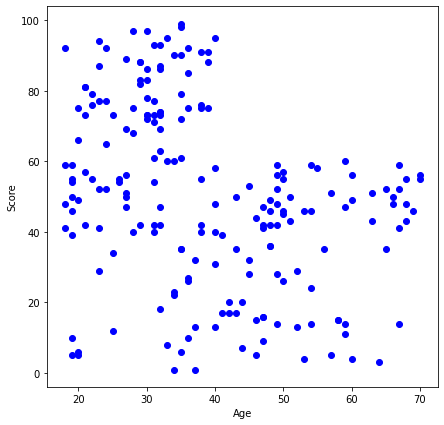

In [6]:
plt.figure(figsize=(7, 7))
plt.scatter( Xv[:, 0], Xv[:, 2], c='blue');
plt.xlabel('Age')
plt.ylabel('Score');

Построим трехмерную картинку. Четко видно как минимум 3 группы точек. Итог - однозначно можно кластеризовать. Но пока непонятно, сколько брать кластеров.

Text(0.5, 0, 'Score')

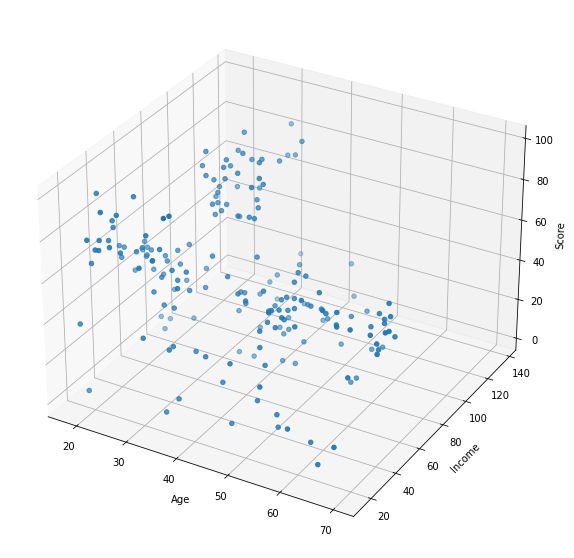

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection = '3d')
ax.scatter3D(Xv[:, 0],Xv[:, 1], Xv[:, 2])
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Score')


Посмотрим, подтверждает ли визуальный анализ статистика Хопкинса

In [8]:
from pyclustertend import hopkins
hopkins(X, 200)

0.31155020368224196

Статистика колеблется около 0,3. В принципе подтверждает. Посмотрим также на инерцию

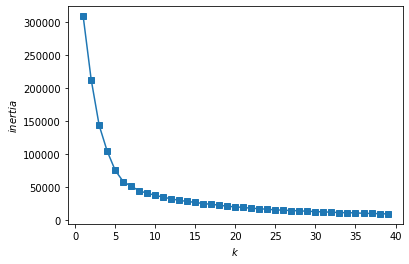

In [12]:
inertia = []
for k in range(1, 40):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 40), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$inertia$');

Ну, на мой взгляд оптимальнее всего брать 5 кластеров. Убывание кривой становится не особо сильным там

/home/nikita/.local/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


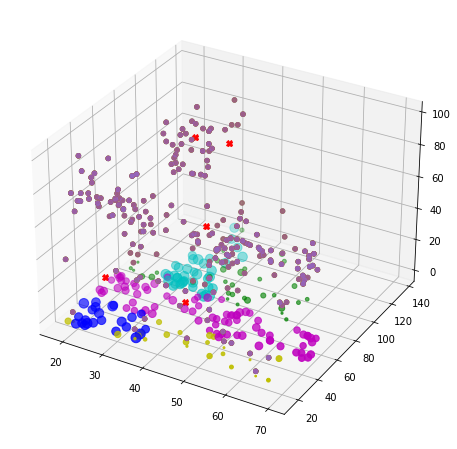

In [19]:
#fit
kmeans = KMeans(n_clusters=5, n_jobs=-1).fit(Xv)
#predict
yhat_kmeans = kmeans.predict(Xv) #=kmeans.labels_

#plot
colors = ['c' if x==0 else 'b' if x==1 else 'g' if x==2 else 'y' if x==3 else 'm' if x==4 else  'black' for x in yhat_kmeans]

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')
for i in range(kmeans.cluster_centers_.shape[0]):
    ax.plot(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], kmeans.cluster_centers_[i, 1], 'rX')
    ax.scatter3D(Xv[:, 0],Xv[:, 1], Xv[:, 2])
plt.scatter(Xv[:,0], Xv[:,1], Xv[:, 2], c=colors, picker=True);

Как видно, более или менее кластеризовалось, но вот фиолетовые бы разделить между собой на 3 группы, а зеленые и бледно-желтые присовокупить к остальным. Попробуем больше кластеров, а именно 6.

/home/nikita/.local/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


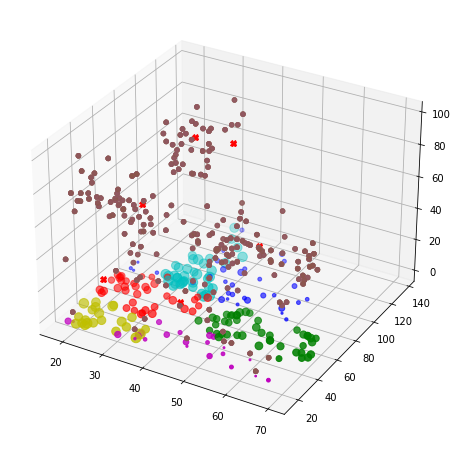

In [20]:
#fit
kmeans = KMeans(n_clusters=6, n_jobs=-1).fit(Xv)
#predict
yhat_kmeans = kmeans.predict(Xv) #=kmeans.labels_

#plot
colors = ['c' if x==0 else 'b' if x==1 else 'g' if x==2 else 'y' if x==3 else 'm' if x==4 else 'r' if x==5  else  'black' for x in yhat_kmeans]

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')
for i in range(kmeans.cluster_centers_.shape[0]):
    ax.plot(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], kmeans.cluster_centers_[i, 1], 'rX')
    ax.scatter3D(Xv[:, 0],Xv[:, 1], Xv[:, 2])

    #plt.plot(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], 'rX')
plt.scatter(Xv[:,0], Xv[:,1], Xv[:, 2], c=colors, picker=True);

Попробуем 7 кластеров

/home/nikita/.local/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


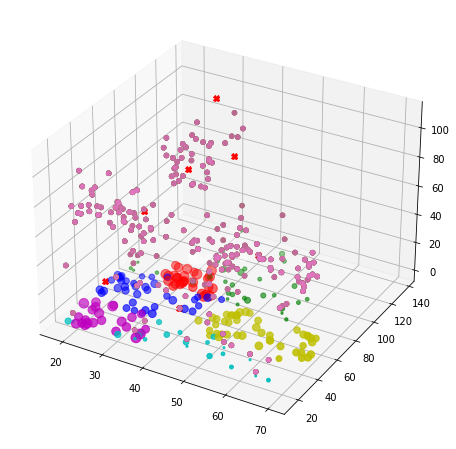

In [21]:
#fit
kmeans = KMeans(n_clusters=7, n_jobs=-1).fit(Xv)
#predict
yhat_kmeans = kmeans.predict(Xv) #=kmeans.labels_

#plot
colors = ['c' if x==0 else 'b' if x==1 else 'g' if x==2 else 'y' if x==3 else 'm' if x==4 else 'r' if x==5 else 'w' if x==6 else  'black' for x in yhat_kmeans]

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = '3d')
for i in range(kmeans.cluster_centers_.shape[0]):
    ax.plot(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], kmeans.cluster_centers_[i, 1], 'rX')
    ax.scatter3D(Xv[:, 0],Xv[:, 1], Xv[:, 2])

    #plt.plot(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], 'rX')
plt.scatter(Xv[:,0], Xv[:,1], Xv[:, 2], c=colors, picker=True);

По-видимому, лучше не станет. В таком случае я бы остановился на 5 кластерах, поскольку для 200 строк их более чем достаточно.

## Задание 2 (по желанию)

Возьмем стандартный датасет ирисов, состоящий из 4-х признаков длины/ширины внутренней и наружной долей околоцветника и таргета - вид цветка (kind).

1.Требуется кластеризовать цветки (да-да, количество кластеров уже известно), посчитать **accuracy**. Выбор алгоритма опять же на усмотрение (может быть несколько)
<br>
**Важно**: метки могут расставиться в другом порядке относительно истинного таргета, то есть после кластеризации будут получены 0, а это на самом деле 1, то есть надо сделать отображение $0 \rightarrow 1$ , то же самое касается и других меток. 
<br>
Поэтому, получив метки кластеров, стоит перебрать все возможные их перестановки. В этом поможет itertools.permutations

2.Воспользоваться любым/любыми пройденными/известными алгоритмами классификации и посчитать **accuracy** 
<br>
(Например, логистической регрессией)

In [5]:
from sklearn import datasets
import itertools

##other libraries on need##

In [6]:
df = datasets.load_iris()
df = pd.DataFrame(np.hstack([df['data'], df['target'].reshape(-1,1)])
             , columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'kind'])

print('Count of unique flowers', df['kind'].unique().shape[0])
df.head()

Count of unique flowers 3


,sepal_length,sepal_width,petal_length,petal_width,kind
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Кластеризация

In [7]:
def validate_with_mappings(y_true, y_pred):
    '''
    Check all possible permutations to maximize accuracy
    '''
    
    l = []
    permutations = itertools.permutations([0, 1, 2])
    for a, b, c in permutations:
        mapping = {0 : a, 1: b, 2: c}
        mapped_preds = [mapping[pred] for pred in y_pred]
        l.append((mapping, sum(mapped_preds == y_true) / len(y_true)))
                 
    return l

In [8]:
X = df.iloc[:, :-1]
y = df['kind']

##твой код с выбором алгоритма ##

### Классификация

In [ ]:
##твой код##

**Вопрос**: что оказалось лучше: алгоритм классификации или кластеризации и на сколько?
<br>
**Ответ**: ****